# Test Region
Avoid making long computations again and again with this notebook!

### Structural Similarity Matrix

In [1]:
from data_loading import *

In [2]:
load_path = "../songs/test"
playlist = load_data(load_path)

In [3]:
print(playlist[0]['song_path'])

../songs/test/ES_Another Kingdom Is Gone (Suedo Remix) (Instrumental Version) - Ingrid Witt.wav


In [25]:
import numpy as np
import scipy
import sklearn

from madmom.features.beats import RNNBeatProcessor
from madmom.features.beats import DBNBeatTrackingProcessor
from madmom.features.key import CNNKeyRecognitionProcessor
from madmom.features.key import key_prediction_to_label

import librosa

import matplotlib.pyplot as plt

In [5]:
def beat_detection(song):
    
    proc = DBNBeatTrackingProcessor(fps=100)
    act = RNNBeatProcessor()(song["song_path"])
    beat_times = proc(act)

    # create the array of ones and zeros
    beat_frames = convert_to_frames(beat_times,song)

    # compute the bpm of the song
    bpm = beats_per_minute(beat_times,song)

    return beat_frames, bpm

def convert_to_frames(beat_times, song):

    beat_frames = (beat_times*song["frame_rate"]).astype(int)
    beat_frames_mapped = np.zeros_like(song["audio_array"])
    beat_frames_mapped[beat_frames] = 1
    
    return beat_frames_mapped

def beats_per_minute(beat_times, song):
    
    song_length = len(song["audio_array"])/song["frame_rate"]/60
    beats_count = len(beat_times)
    
    bpm = beats_count/song_length # We could have problems with the first and the last beat
    
    return bpm

In [6]:
def key_detection(song):

    #key = rubberband/madmom (experiment with both)
    
    proc = CNNKeyRecognitionProcessor()
    key_probabilities = proc(song["song_path"])
    key_label = key_prediction_to_label(key_probabilities)

    return key_probabilities, key_label

In [7]:
def structural_segmentation(song):
    
    ssm = structural_similarity_matrix(song)

    print('Shape')
    print(ssm.shape)

    print(ssm)

    fig, ax = plt.subplots()

    c = ax.pcolormesh(ssm, shading='auto', cmap='magma')
    ax.set_title("MFCC of first 10 seconds (Window size = 100ms)")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("MFCC Features")
    fig.colorbar(c, ax=ax, format='%+02.0f')

    plt.savefig('ssm.png')

    exit()

    cue_points = detect_cue_points(ssm)

    # create the array of ones and zeros

    pass

In [8]:
def structural_similarity_matrix(song):

    samples_per_beat = int(1.0/(song['estimated_bpm']/(60.0 * song['frame_rate'])))

    win_length = int(0.5 * samples_per_beat)
    hop_length = int(0.25 * samples_per_beat)

    print(win_length, hop_length)

    mspec = librosa.feature.melspectrogram(song['audio_array'], sr=song['frame_rate'], n_mels=128, n_fft=samples_per_beat, window="hann", hop_length=hop_length, win_length=win_length)

    print(mspec.shape)

    log_mspec = librosa.power_to_db(mspec, ref=np.max)

    mfcc = librosa.feature.mfcc(S = log_mspec, sr=song['frame_rate'], n_mfcc=13)

    print(mfcc.shape)

    length = mfcc.shape[1]

    print(length)

    ssm = np.zeros((length,length))

    for i in range(length):
        for j in range(length):
            ssm[i,j] = scipy.spatial.distance.cosine(mfcc[:,i], mfcc[:,j])

    return ssm

In [9]:
def detect_cue_points(ssm):
    pass


In [10]:
song = playlist[0]

In [11]:
beats_frames, bpm = beat_detection(song) 
song['beat_times'] = beats_frames # Array like the samples marking with the beat ocurrs, ones/zeros
song['estimated_bpm'] = bpm # Int

/home/javig/.local/lib/python3.6/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [12]:
key_probabilities, key_label = key_detection(song)
song['estimated_key'] = key_label # Probalby string or a int encoding of all the keys
song['key_probabilities'] = key_probabilities

/home/javig/.local/lib/python3.6/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [13]:
samples_per_beat = int(1.0/(song['estimated_bpm']/(60.0 * song['frame_rate'])))

win_length = int(0.5 * samples_per_beat)
hop_length = int(0.25 * samples_per_beat)

print(win_length, hop_length)

11510 5755


In [14]:
mspec = librosa.feature.melspectrogram(song['audio_array'], sr=song['frame_rate'], n_mels=128, n_fft=samples_per_beat, window="hann", hop_length=hop_length, win_length=win_length)

print(mspec.shape)

log_mspec = librosa.power_to_db(mspec, ref=np.max)

(128, 1497)


In [15]:
mfcc = librosa.feature.mfcc(S = log_mspec, sr=song['frame_rate'], n_mfcc=13)

print(mfcc.shape)

(13, 1497)


In [31]:
ssm = sklearn.metrics.pairwise.cosine_similarity(mfcc.T, mfcc.T)

In [32]:
print('Shape')
print(ssm.shape)

print(ssm)

Shape
(1497, 1497)
[[1.         0.97915327 0.96296031 ... 0.95142956 0.95142956 0.95142956]
 [0.97915327 1.         0.9864684  ... 0.97603436 0.97603436 0.97603436]
 [0.96296031 0.9864684  1.         ... 0.97502663 0.97502663 0.97502663]
 ...
 [0.95142956 0.97603436 0.97502663 ... 1.         1.         1.        ]
 [0.95142956 0.97603436 0.97502663 ... 1.         1.         1.        ]
 [0.95142956 0.97603436 0.97502663 ... 1.         1.         1.        ]]


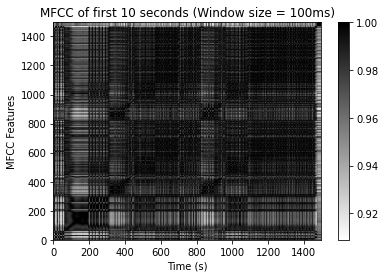

In [33]:
fig, ax = plt.subplots()

c = ax.pcolormesh(ssm, shading='auto', cmap='binary')
ax.set_title("MFCC of first 10 seconds (Window size = 100ms)")
ax.set_xlabel("Time (s)")
ax.set_ylabel("MFCC Features")
fig.colorbar(c, ax=ax)

plt.show()

#plt.savefig('ssm.png')


In [ ]:
ssm = np.zeros((length,length))

for i in range(length):
    for j in range(length):
        ssm[i,j] = scipy.spatial.distance.cosine(mfcc[:,i], mfcc[:,j])